# Imports

In [1]:
# core
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

# sql
import sqlalchemy
from sqlalchemy import create_engine
import pymysql

# SKLearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# models
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import metrics

# Data

## Data Import

In [2]:
df = pd.read_csv('data/trainingData.csv')

## Evaluate Data

In [3]:
df.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [4]:
df.iloc[:, 520:528].dtypes

LONGITUDE           float64
LATITUDE            float64
FLOOR                 int64
BUILDINGID            int64
SPACEID               int64
RELATIVEPOSITION      int64
USERID                int64
PHONEID               int64
dtype: object

## Preprocess

In [5]:
# identify NaNs
df.isnull().values.any() #False

False

In [6]:
# remove any duplicates

df.duplicated().any() # True
df[df.duplicated()].shape #(637, 529)
df = df.drop_duplicates()
df.duplicated().any() #False


False

In [7]:
df.head(1)

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733


# EDA

## Signal strenth histogram

In [8]:
#histogram
dfhist=df

In [9]:
#List of WAP columns and BUILDINGID
col_list=list(range(0,520))
col_list.append(523) #BUILDINGID

In [10]:
dfhist=dfhist.iloc[:,col_list]
#FYI melt - if you don't specify Value_Vars, it assumes all except id_vars(which is good)
dfhist=pd.melt(dfhist, id_vars=['BUILDINGID'])
dfhist=dfhist.loc[dfhist.value < 100]

In [11]:
dfhist

,BUILDINGID,variable,value
7749,0,WAP001,-97
7760,0,WAP001,-95
8199,0,WAP001,-96
8632,0,WAP001,-95
8648,0,WAP001,-94
...,...,...,...
9990101,2,WAP518,-87
9990147,2,WAP518,-87
10005152,0,WAP519,-97
10006036,0,WAP519,-97


<AxesSubplot:xlabel='value', ylabel='Density'>

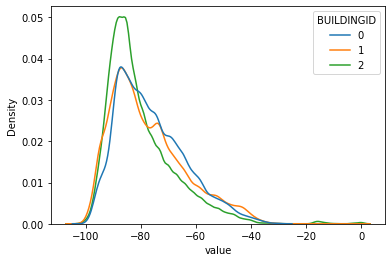

In [12]:
sns.kdeplot(dfhist['value'], hue=dfhist['BUILDINGID'], palette="tab10", common_norm=False)
#.get_figure().savefig('WAP_hist.png')

In [13]:
# observations of each
print(len(dfhist[dfhist.BUILDINGID==0]))
print(len(dfhist[dfhist.BUILDINGID==1]))
print(len(dfhist[dfhist.BUILDINGID==2]))

83072
80851
181157


In [14]:
# avg signal strenth (when detected)
print(dfhist[dfhist.BUILDINGID==0]['value'].mean())
print(dfhist[dfhist.BUILDINGID==1]['value'].mean())
print(dfhist[dfhist.BUILDINGID==2]['value'].mean())

-76.25999133281972
-77.41501032763973
-80.17981640234713


## Long/Lat Map

<AxesSubplot:xlabel='LONGITUDE', ylabel='LATITUDE'>

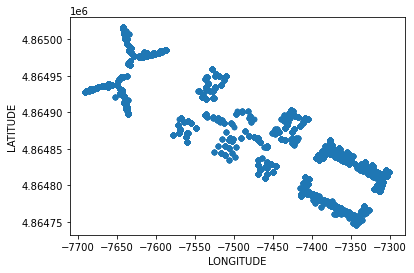

In [15]:
df.plot.scatter(x='LONGITUDE', y='LATITUDE')
#plt.savefig('lat_long.png')

# Modelling Prep

In [16]:
#remove variables that aren't IV or DV
df.drop(columns=['LONGITUDE', 'LATITUDE','USERID', 'PHONEID', 'TIMESTAMP'], inplace=True)

In [17]:
# Create a singular DV (BUILDINGID + FLOOR + SPACEID + RELATIVEPOSITION)
df['Location'] = "B"+df.BUILDINGID.astype(str)+" "+ \
                 "F"+df.FLOOR.astype(str)+" "+ \
                 "S"+df.SPACEID.astype(str)+" "+ \
                 "R"+df.RELATIVEPOSITION.astype(str)

In [18]:
#remove these variables (except building)
df.drop(columns=['FLOOR', 'SPACEID', 'RELATIVEPOSITION'], inplace=True)

In [19]:
#make building=1 data set
dfB0 = df.loc[df.BUILDINGID==0]
#reset index
dfB0.reset_index(drop=True, inplace=True)

In [20]:
#remove building from both data sets
dfB0 = dfB0.drop(columns=['BUILDINGID'])
df.drop(columns=['BUILDINGID'], inplace=True)

In [21]:
dfB0.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,Location
0,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,B0 F0 S122 R2
1,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,B0 F0 S102 R2
2,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,B0 F0 S110 R2
3,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,B0 F0 S111 R2
4,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,B0 F0 S107 R2


## Sampling

In [22]:
seed=123
dfS = df.sample(frac=0.25, random_state=seed)
dfS.shape

(4825, 521)

## Feature Engineering

In [23]:
#add columns for max signal strength and associated WAP.  Keep orig WAP columns
#make a copy of df
dfFE = df.copy(deep=True)
#convert all "100" values to -100
dfFE.replace(100,-100, inplace=True)

In [24]:
#find the max value of each observation
dfFE['max_sig'] = dfFE.iloc[:,0:520].max(axis=1)
dfFE['max_WAP'] = dfFE.iloc[:,0:520].idxmax(axis=1)

In [25]:
labelencoder = LabelEncoder()

In [26]:
#encode df1 to numeric for modelling.  Too many categories to do 1-hot (520)
dfFE['maxWAP_Cat']= labelencoder.fit_transform(dfFE['max_WAP'])

In [27]:
#create a column listing total number of received values in an observation

#copy dfFE WAP columns into new df
#replace -100 with NaN (or make it a T/F df for !=-100)
dftemp = dfFE.iloc[:,0:520].applymap(lambda x: x!=-100)
#count of each row, add it as column to dfFE
dfFE['sig_cnt']=dftemp.sum(axis=1)

In [28]:
#ditch the object columns
dfFE=dfFE.drop(columns=['max_WAP'])
#swap so DV is last
cols = list(dfFE.columns)
a, b = cols.index('Location'), cols.index('sig_cnt')
cols[b], cols[a] = cols[a], cols[b]
dfFE = dfFE[cols]

In [29]:
dfFE.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,sig_cnt,max_sig,maxWAP_Cat,Location
0,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,...,-100,-100,-100,-100,-100,-100,17,-53,147,B1 F2 S106 R2
1,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,...,-100,-100,-100,-100,-100,-100,16,-46,77,B1 F2 S106 R2
2,-100,-100,-100,-100,-100,-100,-100,-97,-100,-100,...,-100,-100,-100,-100,-100,-100,15,-61,146,B1 F2 S103 R2
3,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,...,-100,-100,-100,-100,-100,-100,16,-55,146,B1 F2 S102 R2
4,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,...,-100,-100,-100,-100,-100,-100,0,-100,0,B0 F0 S122 R2


In [30]:
#Sample
dfFES = dfFE.sample(frac=0.25, random_state=seed)
dfFES.shape

(4825, 524)

In [31]:
dfB0.shape

(5246, 521)

# Modelling

## Prepare Data

In [32]:
dfSX = dfS.iloc[:,:-1]
dfB0X = dfB0.iloc[:,:-1]
dfFESX = dfFES.iloc[:,:-1] 

In [33]:
#need our DV to be categorical 
# - use Scikit-Learn's LabelEncoder to keep our DF manageable (due to number of categories)
# creating instance of labelencoder
labelencoder = LabelEncoder()
#encode the DVs
dfSY= labelencoder.fit_transform(dfS['Location'])
dfB0Y= labelencoder.fit_transform(dfB0['Location'])
dfFESY=labelencoder.fit_transform(dfFES['Location'])


In [34]:
X_traindfS, X_testdfS, y_traindfS, y_testdfS = train_test_split(dfSX, dfSY)   
print( X_traindfS.shape )
print( y_traindfS.shape )
print( X_testdfS.shape )
print( y_testdfS.shape )

(3618, 520)
(3618,)
(1207, 520)
(1207,)


In [35]:
X_trainB0, X_testB0, y_trainB0, y_testB0 = train_test_split(dfB0X, dfB0Y)   
print( X_trainB0.shape )
print( y_trainB0.shape )
print( X_testB0.shape )
print( y_testB0.shape )

(3934, 520)
(3934,)
(1312, 520)
(1312,)


In [36]:
X_trainFES, X_testFES, y_trainFES, y_testFES = train_test_split(dfFESX, dfFESY)   
print( X_trainFES.shape )
print( y_trainFES.shape )
print( X_testFES.shape )
print( y_testFES.shape )

(3618, 523)
(3618,)
(1207, 523)
(1207,)


## Create Models

Performed single tests to ensure training time is manageable.

Evaluated KNN, SVM, Gradient Boosting, Decision Trees

Result: GB was both the slowest, and had the lowest accuracy

In [59]:
#eval a single model:
#model=DecisionTreeClassifier()
#result = cross_val_score(model, X_train, y_train)
#print("%0.2f accuracy with a standard deviation of %0.2f" % (result.mean(), result.std()))

In [67]:
models = []
models.append(('DT', DecisionTreeClassifier()))
models.append(('KN', KNeighborsClassifier()))
models.append(('SV', SVC(kernel='linear')))

### Cross-Val dfS (sampled orig data set)

In [51]:
# build models for dfS (sampled orig data set)
results_dfS_CV = []
names_dfS_CV = []
for name, model in models:
    result = cross_val_score(model, X_traindfS, y_traindfS, cv=3)
    names_dfS_CV.append(name)
    results_dfS_CV.append(result)

C:\Users\bmattis\.conda\envs\dataScience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\bmattis\.conda\envs\dataScience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\bmattis\.conda\envs\dataScience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


In [64]:
# evaluate results
for i in range(len(names_dfS_CV)):
    print(names_dfS_CV[i],"accuracy:", results_dfS_CV[i].mean(),"|| max:",results_dfS_CV[i].max(), "|| min: ", results_dfS_CV[i].min())

DT accuracy: 0.3322277501381979 || max: 0.3407960199004975 || min:  0.3250414593698176
KN accuracy: 0.33112216694306246 || max: 0.3341625207296849 || min:  0.32587064676616917
SV accuracy: 0.49447208402432286 || max: 0.5091210613598673 || min:  0.4759535655058043


### Cross-Val dfB0 (Building==0 data set)

In [68]:
results_B0_CV = []
names_B0_CV = []
for name, model in models:
    result = cross_val_score(model, X_trainB0, y_trainB0, cv=3)
    names_B0_CV.append(name)
    results_B0_CV.append(result)

In [69]:
# evaluate results
for i in range(len(names_B0_CV)):
    print(names_B0_CV[i],"accuracy:", results_B0_CV[i].mean(),"|| max:",results_B0_CV[i].max(), "|| min: ", results_B0_CV[i].min())

DT accuracy: 0.5188085648018951 || max: 0.5377574370709383 || min:  0.4927536231884058
KN accuracy: 0.49644057009792064 || max: 0.505720823798627 || min:  0.4843630816170862
SV accuracy: 0.5800709909273005 || max: 0.593440122044241 || min:  0.5659801678108314


### Cross-Val dfFES (Feature engineering, sampled data set)

In [56]:
results_FES_CV = []
names_FES_CV = []
for name, model in models:
    result = cross_val_score(model, X_trainFES, y_trainFES, cv=3)
    names_FES_CV.append(name)
    results_FES_CV.append(result)

C:\Users\bmattis\.conda\envs\dataScience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\bmattis\.conda\envs\dataScience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\bmattis\.conda\envs\dataScience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


In [65]:
# evaluate results
for i in range(len(names_FES_CV)):
    print(names_FES_CV[i],"accuracy:", results_FES_CV[i].mean(),"|| max:",results_FES_CV[i].max(), "|| min: ", results_FES_CV[i].min())

DT accuracy: 0.39607517965726924 || max: 0.412106135986733 || min:  0.37976782752902155
KN accuracy: 0.3971807628524046 || max: 0.40630182421227196 || min:  0.3922056384742952
SV accuracy: 0.6017136539524599 || max: 0.6044776119402985 || min:  0.599502487562189


### Model Optimization: SVC & dfFES

In [66]:
models

[('DT', DecisionTreeClassifier()),
 ('KN', KNeighborsClassifier()),
 ('SV', SVC(kernel='linear'))]

In [70]:
SVmodels = []
SVmodels.append(('SVlin', SVC(kernel='linear')))
SVmodels.append(('SVpoly', SVC(kernel='poly', degree=3)))
SVmodels.append(('SVrbf', SVC(kernel='rbf')))

In [71]:
results_SVopt = []
names_SVopt = []
for name, model in SVmodels:
    result = cross_val_score(model, X_trainFES, y_trainFES, cv=3)
    names_SVopt.append(name)
    results_SVopt.append(result)

C:\Users\bmattis\.conda\envs\dataScience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\bmattis\.conda\envs\dataScience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\bmattis\.conda\envs\dataScience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


In [72]:
# evaluate results
for i in range(len(names_SVopt)):
    print(names_SVopt[i],"accuracy:", results_SVopt[i].mean(),"|| max:",results_SVopt[i].max(), "|| min: ", results_SVopt[i].min())

SVlin accuracy: 0.6017136539524599 || max: 0.6044776119402985 || min:  0.599502487562189
SVpoly accuracy: 0.6017136539524599 || max: 0.6053067993366501 || min:  0.599502487562189
SVrbf accuracy: 0.115257048092869 || max: 0.12437810945273632 || min:  0.10945273631840796


**SVC(linear) and SVC(poly) are matched for best model**

## Model Validation

In [74]:
bestAlg = SVC(kernel='linear')
bestFESPred = bestAlg.fit(X_trainFES, y_trainFES).predict(X_testFES)
print(classification_report(y_testFES, bestFESPred))
print(confusion_matrix(y_testFES, bestFESPred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           7       1.00      0.50      0.67         2
           8       0.00      0.00      0.00         0
           9       1.00      1.00      1.00         1
          12       1.00      0.50      0.67         2
          13       1.00      1.00      1.00         1
          14       0.00      0.00      0.00         0
          15       1.00      1.00      1.00         1
          17       0.00      0.00      0.00         2
          19       0.50      1.00      0.67         2
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         0
          23       1.00    

C:\Users\bmattis\.conda\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bmattis\.conda\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
print("Accuracy:",metrics.accuracy_score(y_testFES, bestFESPred))
print("Precision:",metrics.precision_score(y_testFES, bestFESPred, average='micro'))
print("Recall:",metrics.recall_score(y_testFES, bestFESPred, average='micro'))

Accuracy: 0.632145816072908
Precision: 0.632145816072908
Recall: 0.632145816072908


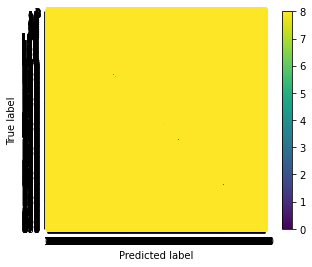

In [91]:
cm = confusion_matrix(y_testFES, bestFESPred, labels=bestAlg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bestAlg.classes_)
#.get_figure().savefig('WAP_hist.png')
disp.plot() 

In [93]:
#alternate method of plotting a confusion matrix
#plot_confusion_matrix(bestAlg, X_testFES, y_testFES)  
#plt.savefig('ConfusionMatrix2.png')
#plt.show() 

Too many classes exist for a confusion matrix to be useful

### If time allows, consider attempting to model with full FE data set

High number of classes means we're not giving it many examples of each class to train with.  More could
potentially improve accuracy

In [31]:
dfFEX = dfFE.iloc[:,:-1] 
dfFEY=labelencoder.fit_transform(dfFE['Location'])
X_trainFE, X_testFE, y_trainFE, y_testFE = train_test_split(dfFEX, dfFEY)   
print( X_trainFE.shape )
print( y_trainFE.shape )
print( X_testFE.shape )
print( y_testFE.shape )

(14475, 523)
(14475,)
(4825, 523)
(4825,)


In [32]:
bestAlg = SVC(kernel='linear')
bestFEPred = bestAlg.fit(X_trainFE, y_trainFE).predict(X_testFE)
print(classification_report(y_testFE, bestFEPred))
print(confusion_matrix(y_testFE, bestFEPred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       0.12      0.25      0.17         4
           5       0.57      0.57      0.57         7
           6       0.67      0.67      0.67         6
           7       0.88      0.88      0.88         8
           8       1.00      1.00      1.00         2
           9       1.00      0.83      0.91         6
          10       0.29      0.67      0.40         3
          11       0.40      0.40      0.40         5
          12       1.00      0.50      0.67         8
          13       0.91      0.91      0.91        11
          14       1.00      0.67      0.80         6
          15       0.60      0.60      0.60         5
          16       0.67      0.57      0.62         7
          17       1.00    

C:\Users\bmattis\.conda\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bmattis\.conda\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
print("Accuracy:",metrics.accuracy_score(y_testFE, bestFEPred))
print("Precision:",metrics.precision_score(y_testFE, bestFEPred, average='weighted'))
print("Recall:",metrics.recall_score(y_testFE, bestFEPred, average='macro'))

Accuracy: 0.813678756476684
Precision: 0.8464188768912297
Recall: 0.8074849245098902
